# UCI Dataset: Log-Linear Model v.s. Autoencoder

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from ucimlrepo import fetch_ucirepo

from joblib import Parallel, delayed

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import ld

In [2]:
def find_factorization(D):
    factors = []

    # Try to find a factorization with 3 factors first
    for a in range(2, int(D**(1/3)) + 2):
        if D % a == 0:
            bc = D // a
            for b in range(a, int(bc**(1/2)) + 2):
                if bc % b == 0:
                    c = bc // b
                    factors.append((a, b, c))
                    return factors

    # If 3-factor factorization is not found, try 2-factor factorization
    for a in range(2, int(D**(1/2)) + 2):
        if D % a == 0:
            b = D // a
            factors.append((a, b))
            return factors

    return factors

def vectorize_tensor(T, B):
    """
    Vectorizes the tensor T by selecting only the indices in B.

    Parameters:
    - T: numpy array of shape (num_samples, ...)
    - B: list of indices to select from each sample

    Returns:
    - V: vectorized representation of T of shape (num_samples, len(B))
    """
    num_samples = T.shape[0]
    V = np.zeros((num_samples, len(B)))
    for i in range(num_samples):
        for j, idx in enumerate(B):
            V[i, j] = T[i, *idx]
    return V

def reconstruct_tensor(V, T_shape, B):
    """
    Reconstructs the tensor T from its vectorized representation V.

    Parameters:
    - V: vectorized representation of T of shape (num_samples, len(B))
    - T_shape: original shape of the tensor T
    - B: list of indices that were used to create the vectorized representation

    Returns:
    - T: reconstructed tensor with the original shape, missing values filled with zero
    """
    num_samples = V.shape[0]
    T = np.zeros(T_shape)
    for i in range(num_samples):
        for j, idx in enumerate(B):
            T[i, *idx] = V[i, j]
    return T

## Basic Logistic Regression

### Dataset

In [3]:
UCI_id = 464

In [4]:
UCI_dataset = fetch_ucirepo(id=UCI_id)

X = np.array(UCI_dataset.data.features)
Y = np.array(UCI_dataset.data.targets)

# Print the shape of features and labels
print("Shape of features:", X.shape)
print("Shape of labels:", Y.shape)

# Normalize the input data
# X_mean = np.mean(X, axis=0)
# X_std = np.std(X, axis=0)
# X = normalization(X, X_mean, X_std)

# Create an array of indices
indices = np.arange(len(Y))
np.random.shuffle(indices)

# Use the shuffled indices to randomly select data for training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Shape of features: (21263, 81)
Shape of labels: (21263, 1)


In [5]:
print(X.min(), X.max())
print(Y.min(), Y.max())

# Stacking the features and labels together
# X = np.hstack((X_train, Y_train.reshape(-1, 1)))

0.0 22590.0
0.00021 185.0


In [6]:
# Feature dimension
D = X_train.shape[1]
S = find_factorization(D)[0]
S = (3, 3, 3, 3)
print("Tensor Structure of the Feature:", S)
X = [np.asarray(x).reshape(S) for x in X_train]

Tensor Structure of the Feature: (3, 3, 3, 3)


## Data Generation

### Legendre Decomposition

In [7]:
B_LD = ld.default_B(S, 2, cp.get_array_module(X[0]))
# B_LD = step_B(S, (1, 2, 2))

scaleX_list = []
theta_list = []

def helper(x):
    _, _, scaleX, _, theta = ld.LD(x, B=B_LD, verbose=False, n_iter=1000, lr=1e-1)
    return (scaleX, theta)

results = Parallel(n_jobs=30)(delayed(helper)(x) for x in X)

for i in range(len(results)):
    scaleX_list.append(results[i][0])
    theta_list.append(results[i][1])

scaleX_list = np.array(scaleX_list)
theta_list = np.array(theta_list)

### Fitting and Sampling

In [22]:
from sklearn.neighbors import KernelDensity

num_new_samples = 160

reduced_theta = vectorize_tensor(np.array(theta_list), B_LD)

# Fit a KDE to the theta values
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(reduced_theta)
# Sample new data from the KDE
sampled_reduced_theta = kde.sample(n_samples=num_new_samples)

sampled_theta_list = reconstruct_tensor(sampled_reduced_theta, (num_new_samples, *S), B_LD)

#### Construct Submanifold

In [23]:
# Construct the constrained coordinates
B_BP = ld.default_B(S, 1, cp.get_array_module(X[0]))

print(B_BP.shape)

# Compute every datapoint's eta_hat (served as the linear constraints)
eta_hat_list = []
for i in range(len(X)):
    x = X[i]
    eps = np.asarray(1.0e-5)
    xp = cp.get_array_module(x)
    eta_hat = ld.get_eta((x + eps) / scaleX_list[i], len(S), xp)
    eta_hat_list.append(eta_hat)
eta_hat_list = cp.asarray(eta_hat_list)

(4, 3)


#### Backward Projection

In [25]:
sampled_P_list_BP = []
sampled_theta_list_BP = []
X_recons_list = []
Y_recons_list = []

def helper2(i):
    ks = ld.kNN(sampled_theta_list[i], np.array(theta_list), k=10)
    Y_recons = np.mean(Y_train[ks])
    avg_scale = np.mean(np.array(scaleX_list)[ks], axis=0)
    avg_eta_hat = np.mean(eta_hat_list[ks], axis=0)
    _, _, P, theta = ld.BP(sampled_theta_list[i], [(X[k] + eps) / scaleX_list[k] for k in ks], avg_eta_hat, avg_scale, B=B_BP, verbose=False, n_iter=1000, lr=5e-2, exit_abs=True)
    X_recons = (P).astype(np.int32).reshape(-1)
    return (P, theta, X_recons, Y_recons)

results = Parallel(n_jobs=30)(delayed(helper2)(i) for i in range(num_new_samples))

for i in range(len(results)):
    sampled_P_list_BP.append(results[i][0])
    sampled_theta_list_BP.append(results[i][1])
    X_recons_list.append(results[i][2])
    Y_recons_list.append(results[i][3])

sampled_P_list_BP = np.array(sampled_P_list_BP)
sampled_theta_list_BP = np.array(sampled_theta_list_BP)
X_recons_list = np.array(X_recons_list)
Y_recons_list = np.array(Y_recons_list)

In [28]:
print(sampled_P_list_BP.shape)
print(sampled_theta_list_BP.shape)
print(X_recons_list.shape)
print(Y_recons_list.shape)

(160, 2, 2, 2)
(160, 2, 2, 2)
(160, 8)
(160,)


## Generated Data Quality

In [26]:
# Train a linear regression model
lr = LinearRegression()
lr.fit(X_train, Y_train)

# Predict on the test set
Y_test_pred = lr.predict(X_test)

# Evaluate the model performance
mae = mean_absolute_error(Y_test, Y_test_pred)
mse = mean_squared_error(Y_test, Y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_test_pred)

# Print the performance metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Measure the accuracy on the test set
accuracy = lr.score(X_test, Y_test)
print("Accuracy on the test set:", accuracy)

Mean Absolute Error (MAE): 7.75
Mean Squared Error (MSE): 95.97
Root Mean Squared Error (RMSE): 9.80
R-squared (R2): 0.63
Accuracy on the test set: 0.6275531792314855


### Trained on Generated Data

In [27]:
# Convert lists to numpy arrays
# X_train_new = X_recons_list[:, :-1]
# print(X_train_new.shape)
# Y_train_new = X_recons_list[:, -1]
# print(Y_train_new.shape)

X_train_new = np.array(X_recons_list)
Y_train_new = np.array(Y_recons_list)

# Train a linear regression model
lr = LinearRegression()
lr.fit(X_train_new, Y_train_new)

# Predict on the test set
Y_test_pred = lr.predict(X_test)

# Evaluate the model performance
mae = mean_absolute_error(Y_test, Y_test_pred)
mse = mean_squared_error(Y_test, Y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_test_pred)

# Print the performance metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Measure the accuracy on the test set
accuracy = lr.score(X_test, Y_test)
print("Accuracy on the test set:", accuracy)

Mean Absolute Error (MAE): 22.35
Mean Squared Error (MSE): 604.62
Root Mean Squared Error (RMSE): 24.59
R-squared (R2): -1.35
Accuracy on the test set: -1.3464263251771693


Accuracy on the test set: 0.8076923076923077


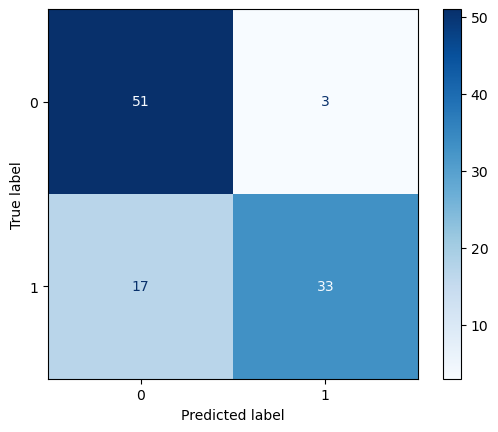

In [12]:
# Convert lists to numpy arrays
X_train_with_new = np.concatenate((X_train, X_train_new))
Y_train_with_new = np.concatenate((Y_train, Y_train_new))

# Train a logistic classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_with_new, Y_train_with_new)

# Measure the accuracy on the test set
accuracy = clf.score(X_test, Y_test)
print("Accuracy on the test set:", accuracy)

# Optional: Display the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(Y_test, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()